In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/15442/project/code/CNNQuantizer

/content/gdrive/.shortcut-targets-by-id/1J-ev4hm2MhC4v6IrbV0Di-bW2BCbf5hy/project/code/CNNQuantizer


In [3]:
!pwd

/content/gdrive/.shortcut-targets-by-id/1J-ev4hm2MhC4v6IrbV0Di-bW2BCbf5hy/project/code/CNNQuantizer


In [4]:
import os
import torch
import copy
import numpy as np
from utils import set_random_seeds, train_model, evaluate_model, calibrate_model, save_model, load_model, evaluate_mixed_model
from resnet18 import ResNet
from model import create_model, model_equivalence, QuantizedResNet18
from dataset import prepare_dataloader
from weight_aware_quantizer import WeightAwareQuantizer

In [5]:
%cd /content/

/content


In [6]:
random_seed = 0
num_classes = 10
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu")

model_dir = "/content/gdrive/MyDrive/15442/project/data/"
model_filename = "resnet18_cifar10_10epoch.pt"
fused_model_filename="resnet18_fused_cifar10_10epoch.pt"
quantized_model_filename = "resnet18_quantized_cifar10_10epoch.pt"
model_filepath = os.path.join(model_dir, model_filename)
fused_model_filepath = os.path.join(model_dir, fused_model_filename)
quantized_model_filepath = os.path.join(model_dir, quantized_model_filename)

set_random_seeds(random_seed=random_seed)

In [7]:
train_loader, test_loader = prepare_dataloader(num_workers=8, train_batch_size=128, eval_batch_size=256)
# Create an untrained model.
model = create_model(num_classes=num_classes)

100%|██████████| 170498071/170498071 [00:03<00:00, 48398741.90it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# Load a pretrained model.
model = load_model(model=model, model_filepath=model_filepath, device='cpu')

In [9]:
# Make a copy of the model for layer fusion
fused_model = copy.deepcopy(model)
model.eval()
# The model has to be switched to evaluation mode before any layer fusion.
# Otherwise the quantization will not work correctly.
fused_model.eval()

# Fuse the model in place rather manually.
fused_model = torch.ao.quantization.fuse_modules(fused_model, [["conv1", "bn1", "relu"]], inplace=True)
for module_name, module in fused_model.named_children():
    if "layer" in module_name:
        for basic_block_name, basic_block in module.named_children():
            torch.ao.quantization.fuse_modules(basic_block, [["conv1", "bn1", "relu1"], ["conv2", "bn2"]], inplace=True)
            for sub_block_name, sub_block in basic_block.named_children():
                if sub_block_name == "downsample":
                    torch.ao.quantization.fuse_modules(sub_block, [["0", "1"]], inplace=True)

# Model and fused model should be equivalent.
assert model_equivalence(model_1=model, model_2=fused_model, device=cpu_device, rtol=1e-03, atol=1e-06, num_tests=100, input_size=(1,3,32,32)), "Fused model is not equivalent to the original model!"


In [10]:
print(fused_model)

ResNet(
  (conv1): ConvReLU2d(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
  )
  (bn1): Identity()
  (relu): Identity()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (bn1): Identity()
      (relu1): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Identity()
      (skip_add): FloatFunctional(
        (activation_post_process): Identity()
      )
      (relu2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (bn1): Identity()
      (relu1): Identity()
      (conv2): Conv2d(64, 64, kernel_size=

# Model Weight Study
Note: Only weight & activation quantized, bias not quantized

Selected useful experiments and plots presented here. Please see Sparsity notebook for all experiments done.

In [11]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [12]:
img_result_path = "/content/gdrive/MyDrive/15442/project/results/"

----------------------------------------------------
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))


100%|██████████| 64/64 [00:00<00:00, 2867.90it/s]


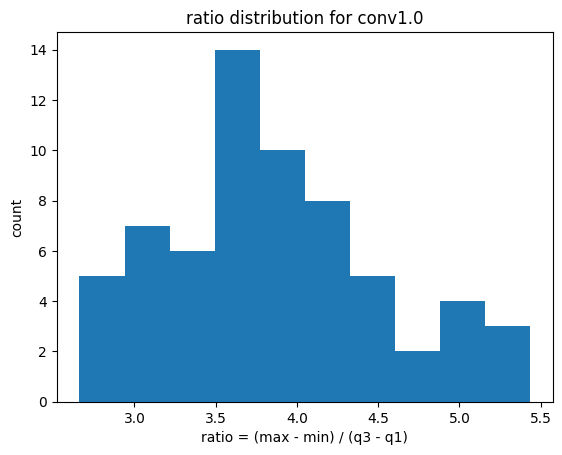

----------------------------------------------------
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 64/64 [00:00<00:00, 2513.61it/s]


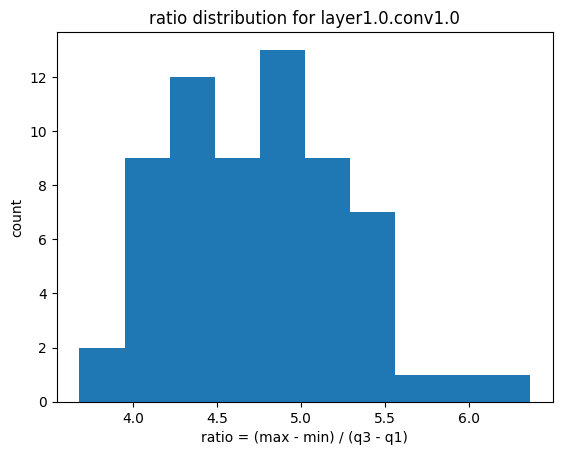

----------------------------------------------------
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 64/64 [00:00<00:00, 1932.80it/s]


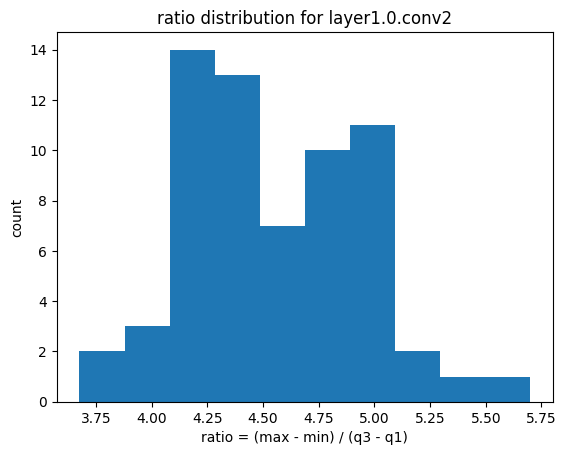

----------------------------------------------------
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 64/64 [00:00<00:00, 2338.37it/s]


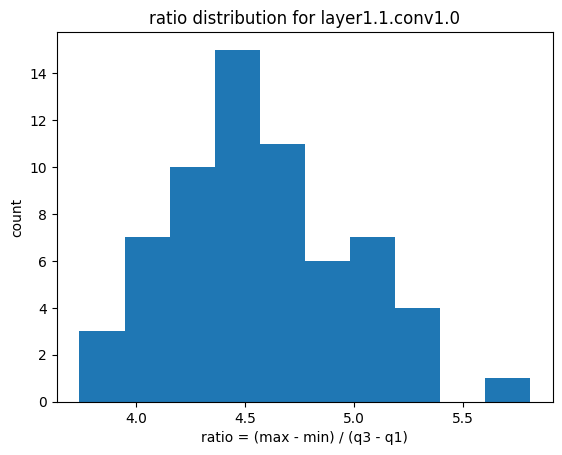

----------------------------------------------------
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 64/64 [00:00<00:00, 2589.08it/s]


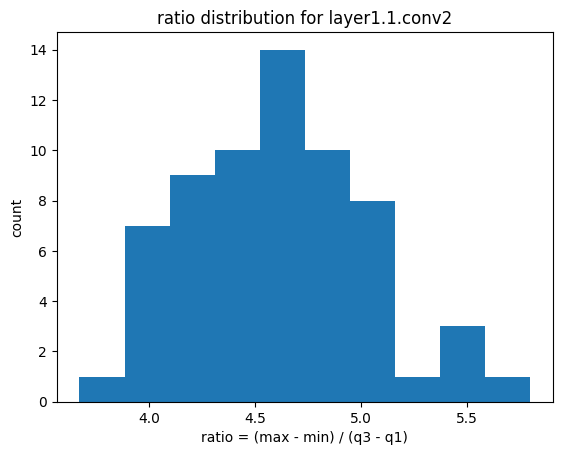

----------------------------------------------------
Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


100%|██████████| 128/128 [00:00<00:00, 2755.67it/s]


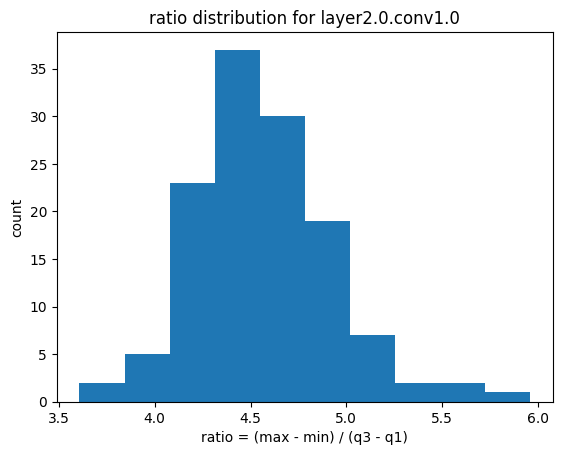

----------------------------------------------------
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 128/128 [00:00<00:00, 2252.32it/s]


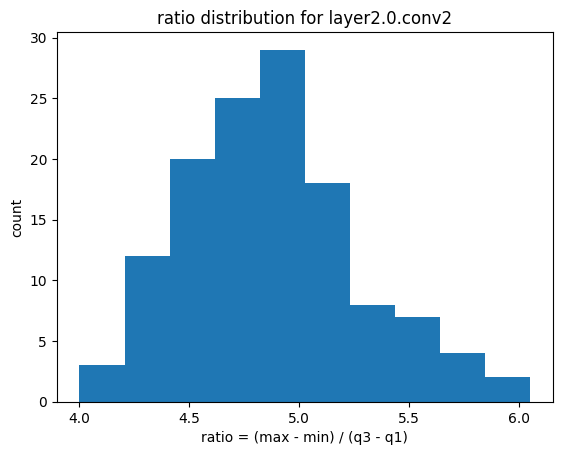

----------------------------------------------------
Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))


100%|██████████| 128/128 [00:00<00:00, 3436.68it/s]


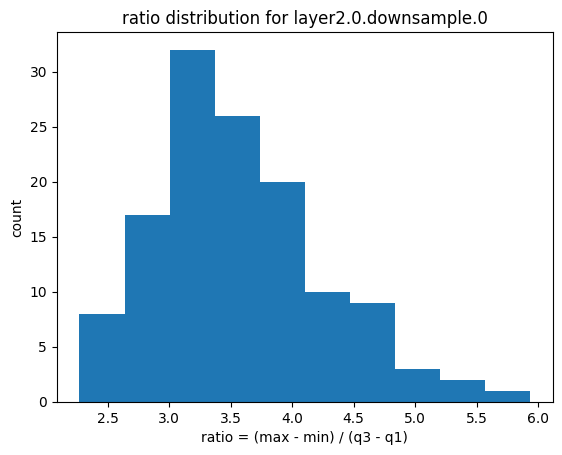

----------------------------------------------------
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 128/128 [00:00<00:00, 2207.98it/s]


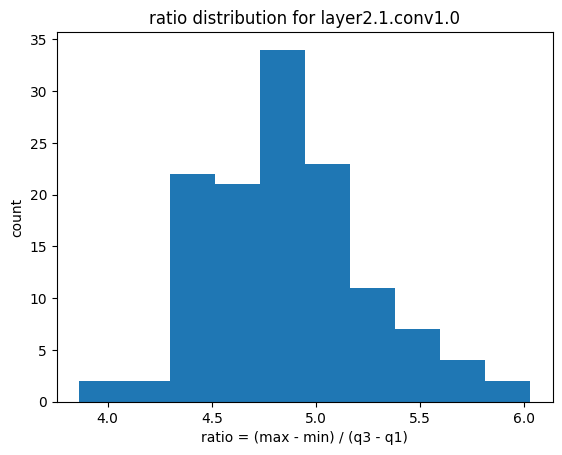

----------------------------------------------------
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 128/128 [00:00<00:00, 2148.10it/s]


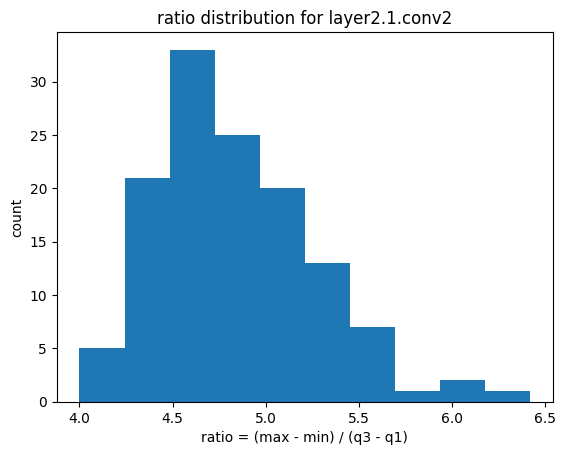

----------------------------------------------------
Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


100%|██████████| 256/256 [00:00<00:00, 1930.30it/s]


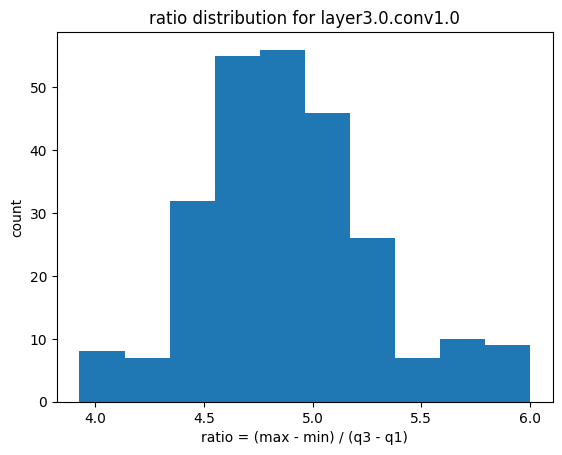

----------------------------------------------------
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 256/256 [00:00<00:00, 1794.07it/s]


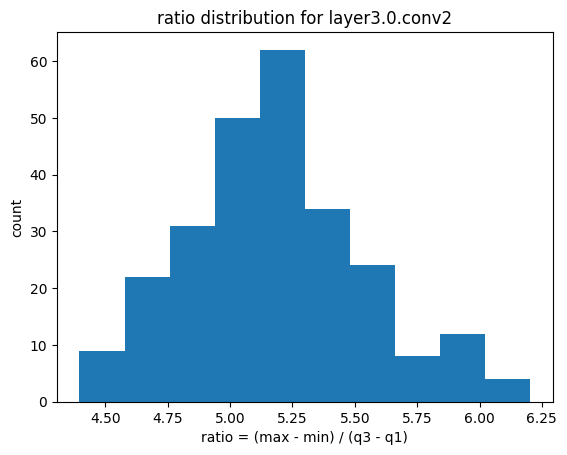

----------------------------------------------------
Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))


100%|██████████| 256/256 [00:00<00:00, 3724.11it/s]


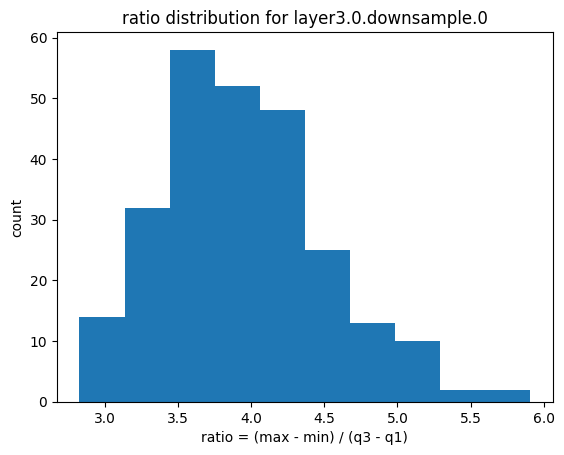

----------------------------------------------------
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 256/256 [00:00<00:00, 1730.74it/s]


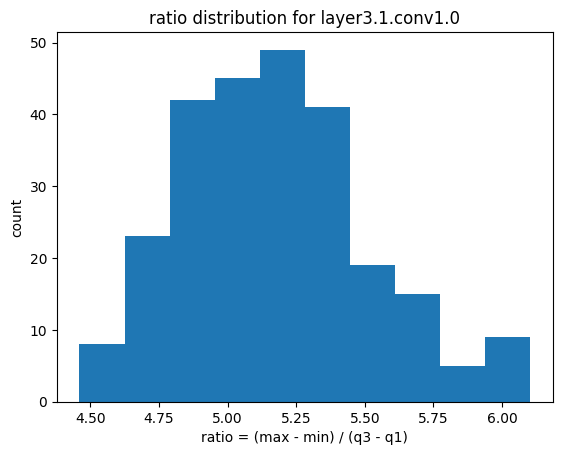

----------------------------------------------------
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 256/256 [00:00<00:00, 1524.81it/s]


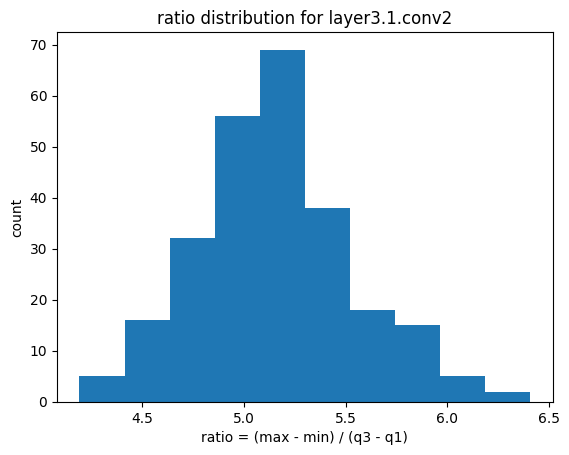

----------------------------------------------------
Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


100%|██████████| 512/512 [00:00<00:00, 1420.57it/s]


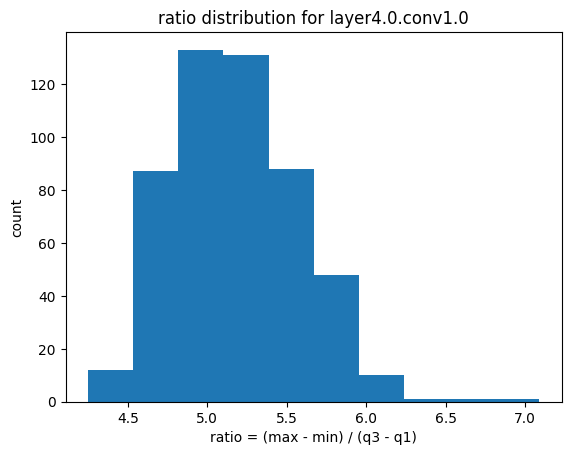

----------------------------------------------------
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 512/512 [00:00<00:00, 965.70it/s] 


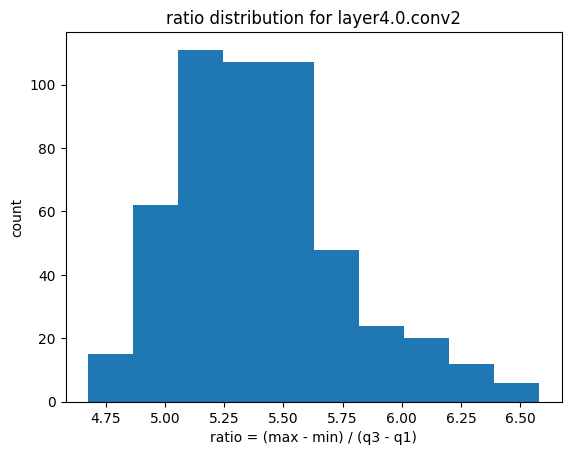

----------------------------------------------------
Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))


100%|██████████| 512/512 [00:00<00:00, 2914.17it/s]


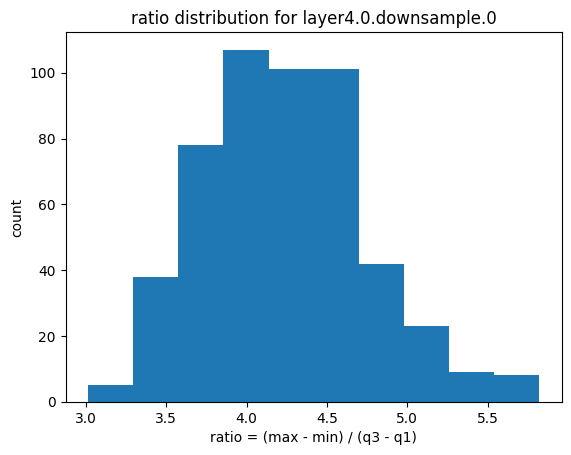

----------------------------------------------------
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 512/512 [00:00<00:00, 721.06it/s]


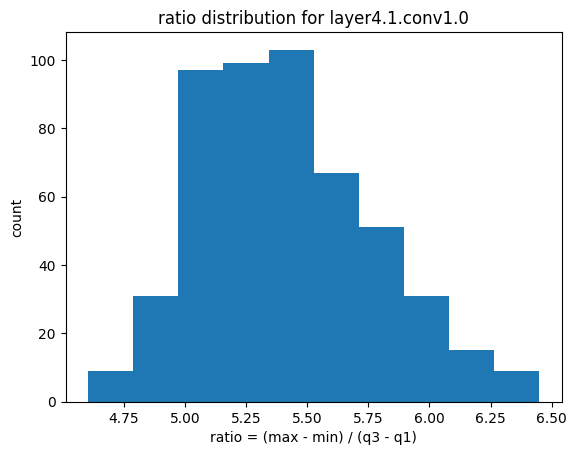

----------------------------------------------------
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 512/512 [00:00<00:00, 764.14it/s]


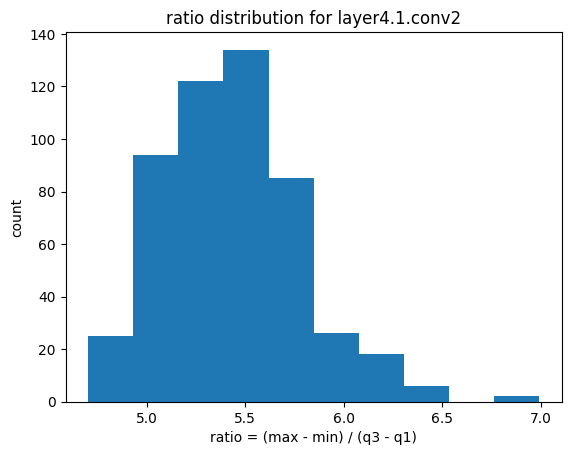

<Figure size 640x480 with 0 Axes>

In [14]:
# plot fused model per_in_channel ratio = (max - min) / (q3 - q1) distribution on the per_out_channel basis for conv modules

def measure_conv_module_stats(img_name, module, module_name):
    param = module.weight
    ratio_array = np.zeros(param.shape[0])

    for i in tqdm(range(param.shape[0])):
      # ratio = (max - min) / (q3 - q1)
      max_val = torch.amax(param[i], dim=(0, 1, 2)).item()
      min_val = torch.amin(param[i], dim=(0, 1, 2)).item()
      quantiles = torch.tensor([0.25, 0.75])
      cur_in_channel_vals = param[i].flatten()
      quantile_vals = torch.quantile(cur_in_channel_vals, quantiles, dim=0)
      q1, q3 = quantile_vals[0].item(), quantile_vals[1].item()
      ratio_array[i] = (max_val - min_val) / (q3 - q1)

    # plt.hist(ratio_array, facecolor="None", edgecolor='b')
    plt.hist(ratio_array)
    plt.xlabel("ratio = (max - min) / (q3 - q1)")
    plt.ylabel("count")
    plt.title("ratio distribution for " + module_name)
    # plt.savefig(img_name)
    plt.show()
    plt.clf()


def measure_conv_global_stats(model):

    image_idx = 0
    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            print("----------------------------------------------------")
            print(module)
            image_name = img_result_path + str(image_idx)
            measure_conv_module_stats(image_name, module, module_name)
            image_idx += 1


measure_conv_global_stats(fused_model)

----------------------------------------------------
Linear(in_features=512, out_features=10, bias=True)
Linear layer ((max_val - min_val) / (q3 - q1)) ratio = 6.300600528717041


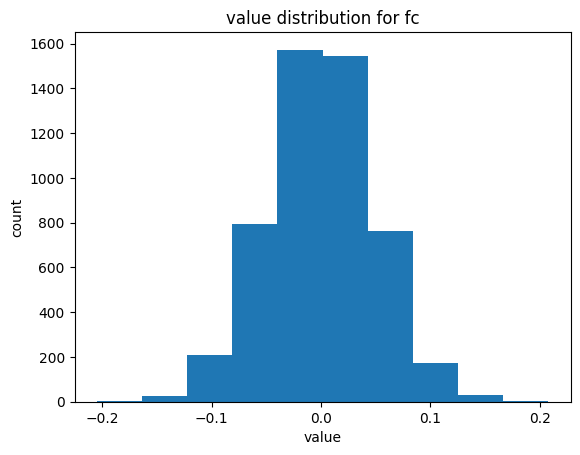

<Figure size 640x480 with 0 Axes>

In [28]:
# plot fused model nn.Linear layer param dis

def measure_linear_module_stats(module, module_name):

    param = module.weight
    flattened_param = param.flatten()
    quantiles = torch.tensor([0.25, 0.75])
    quantile_vals = torch.quantile(flattened_param, quantiles, dim=0)
    q1, q3 = quantile_vals[0].item(), quantile_vals[1].item()
    ratio = (torch.max(flattened_param) - torch.min(flattened_param)) / (q3 - q1)
    print("Linear layer ((max_val - min_val) / (q3 - q1)) ratio = " + str(ratio.item()))

    plt.hist(flattened_param.detach().numpy())
    # plt.savefig(img_result_path + "fused_nn_Linear")
    plt.xlabel("value")
    plt.ylabel("count")
    plt.title("value distribution for " + module_name)
    plt.show()
    plt.clf()


def measure_linear_stats(model):
    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            print("----------------------------------------------------")
            print(module)
            measure_linear_module_stats(module, module_name)


measure_linear_stats(fused_model)

-----version 2--------
Conv2d with name:  conv1.0


100%|██████████| 64/64 [00:00<00:00, 1728.11it/s]


successfully extract extreme value out from  conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv1.0


100%|██████████| 64/64 [00:00<00:00, 498.54it/s]


successfully extract extreme value out from  layer1.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv2


100%|██████████| 64/64 [00:00<00:00, 614.70it/s]


successfully extract extreme value out from  layer1.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv1.0


100%|██████████| 64/64 [00:00<00:00, 681.53it/s]


successfully extract extreme value out from  layer1.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv2


100%|██████████| 64/64 [00:00<00:00, 709.76it/s]


successfully extract extreme value out from  layer1.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv1.0


100%|██████████| 128/128 [00:00<00:00, 707.15it/s]


successfully extract extreme value out from  layer2.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv2


100%|██████████| 128/128 [00:00<00:00, 376.26it/s]


successfully extract extreme value out from  layer2.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.downsample.0
Conv2d with name:  layer2.1.conv1.0


100%|██████████| 128/128 [00:00<00:00, 370.49it/s]


successfully extract extreme value out from  layer2.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.1.conv2


100%|██████████| 128/128 [00:00<00:00, 385.92it/s]


successfully extract extreme value out from  layer2.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv1.0


100%|██████████| 256/256 [00:00<00:00, 384.14it/s]


successfully extract extreme value out from  layer3.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv2


100%|██████████| 256/256 [00:01<00:00, 145.50it/s]


successfully extract extreme value out from  layer3.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.downsample.0
Conv2d with name:  layer3.1.conv1.0


100%|██████████| 256/256 [00:01<00:00, 131.00it/s]


successfully extract extreme value out from  layer3.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.1.conv2


100%|██████████| 256/256 [00:01<00:00, 204.11it/s]


successfully extract extreme value out from  layer3.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv1.0


100%|██████████| 512/512 [00:02<00:00, 183.35it/s]


successfully extract extreme value out from  layer4.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv2


100%|██████████| 512/512 [00:04<00:00, 106.13it/s]


successfully extract extreme value out from  layer4.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.downsample.0
Conv2d with name:  layer4.1.conv1.0


100%|██████████| 512/512 [00:06<00:00, 82.30it/s] 


successfully extract extreme value out from  layer4.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.1.conv2


100%|██████████| 512/512 [00:04<00:00, 104.54it/s]


successfully extract extreme value out from  layer4.1.conv2  and replace with per in channel mean vals
Linear with name:  fc
successfully extract extreme value out from  fc  and replace with per in channel mean vals
Finish process fused model
----------------------------------------------------
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))


100%|██████████| 64/64 [00:00<00:00, 4908.40it/s]


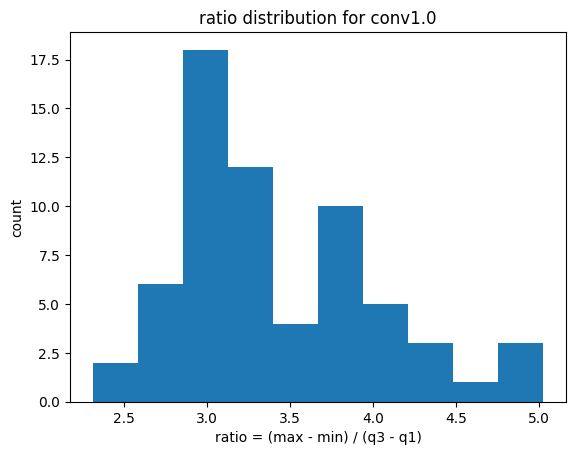

----------------------------------------------------
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 64/64 [00:00<00:00, 3447.23it/s]


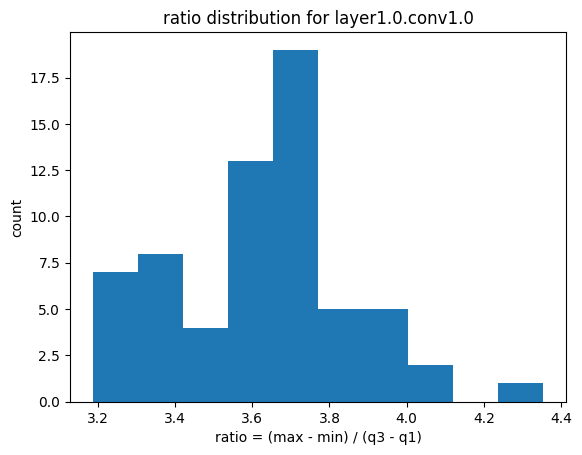

----------------------------------------------------
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 64/64 [00:00<00:00, 3073.91it/s]


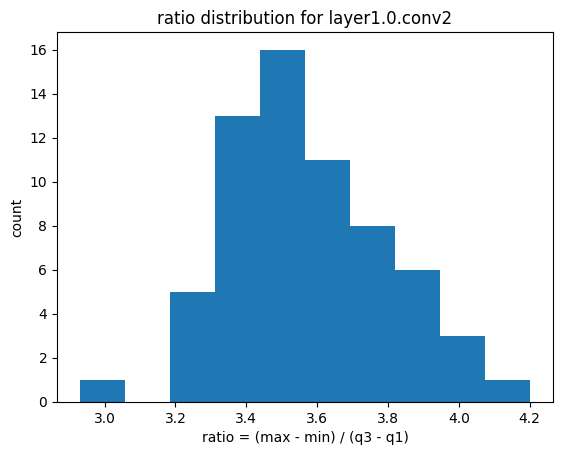

----------------------------------------------------
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 64/64 [00:00<00:00, 2257.49it/s]


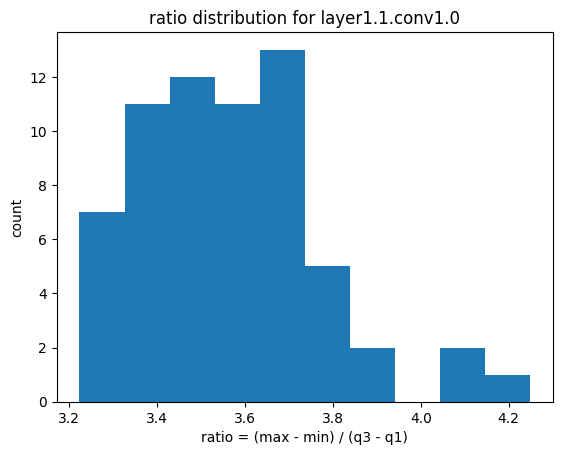

----------------------------------------------------
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 64/64 [00:00<00:00, 2281.61it/s]


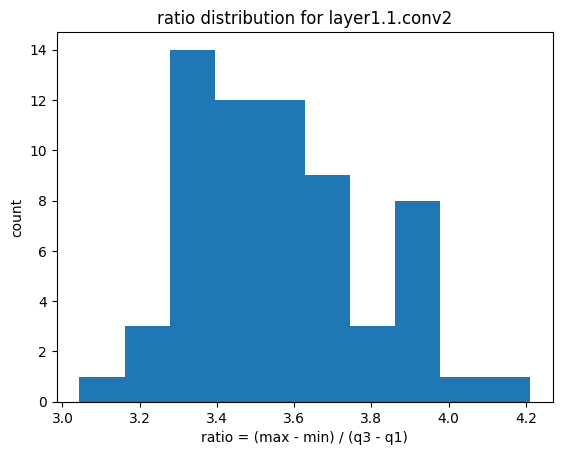

----------------------------------------------------
Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


100%|██████████| 128/128 [00:00<00:00, 2527.97it/s]


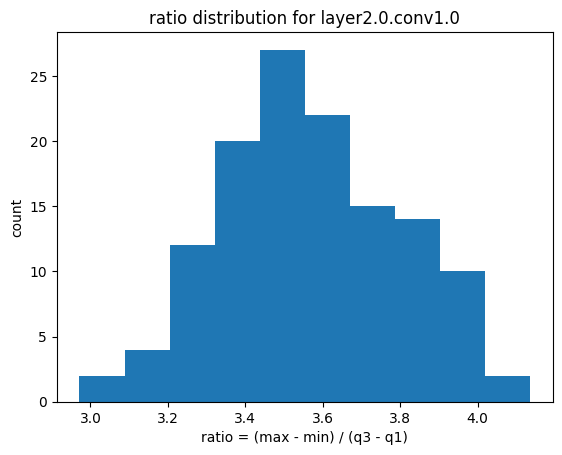

----------------------------------------------------
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 128/128 [00:00<00:00, 2516.48it/s]


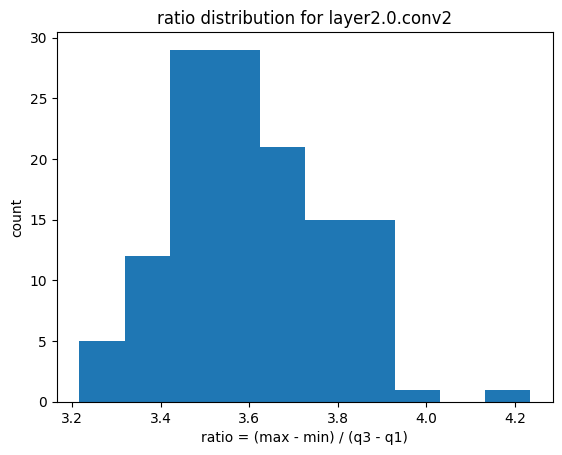

----------------------------------------------------
Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))


100%|██████████| 128/128 [00:00<00:00, 2741.18it/s]


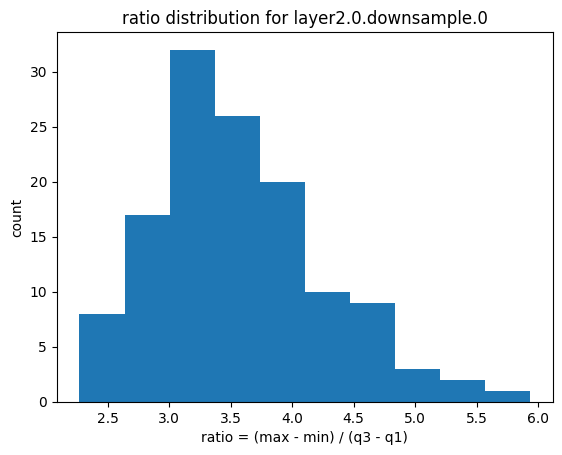

----------------------------------------------------
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 128/128 [00:00<00:00, 692.07it/s]


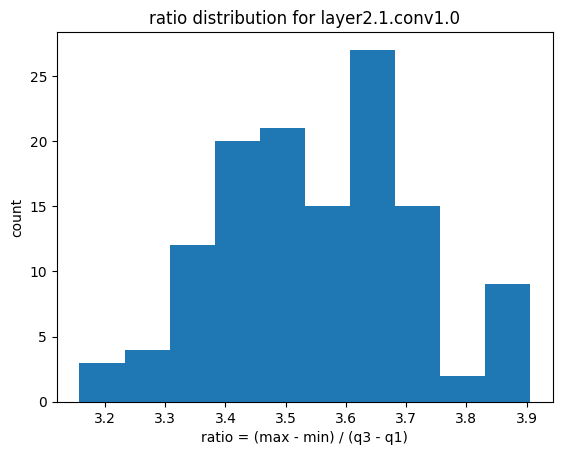

----------------------------------------------------
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 128/128 [00:00<00:00, 517.91it/s]


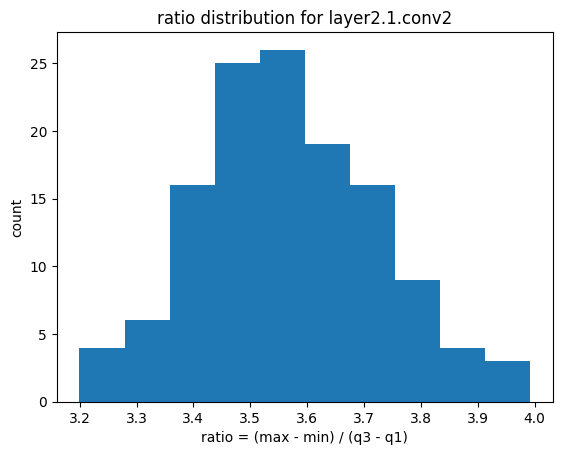

----------------------------------------------------
Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


100%|██████████| 256/256 [00:00<00:00, 541.45it/s]


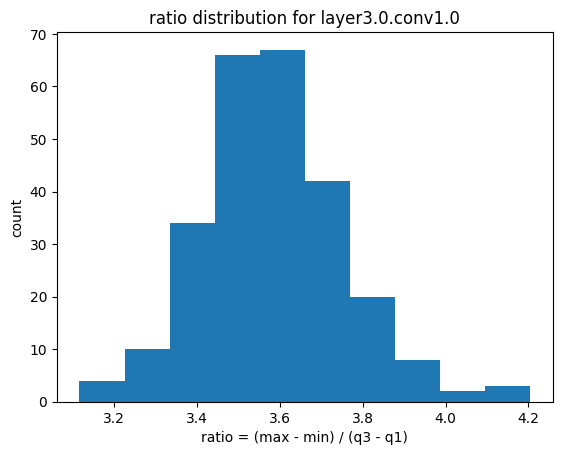

----------------------------------------------------
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 256/256 [00:00<00:00, 1490.49it/s]


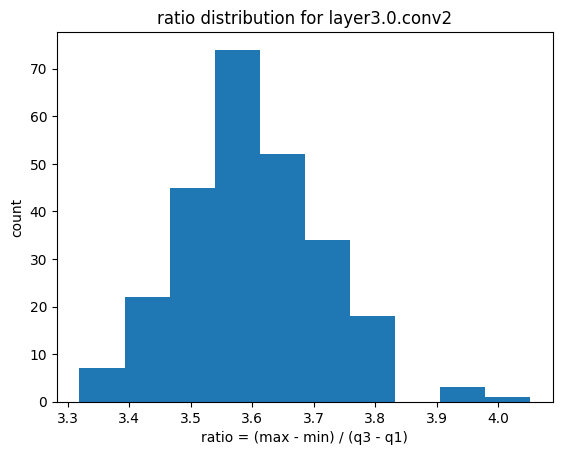

----------------------------------------------------
Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))


100%|██████████| 256/256 [00:00<00:00, 4340.30it/s]


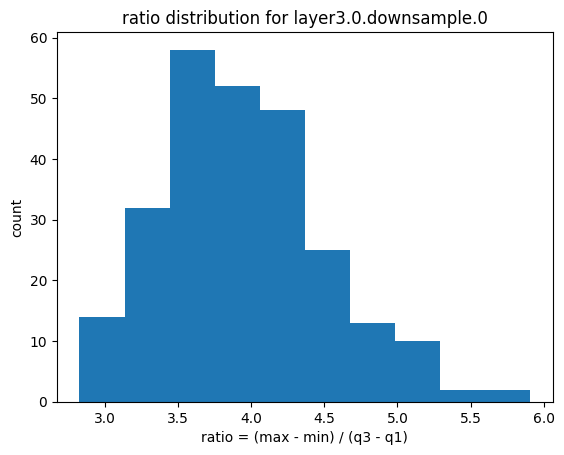

----------------------------------------------------
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 256/256 [00:00<00:00, 1926.68it/s]


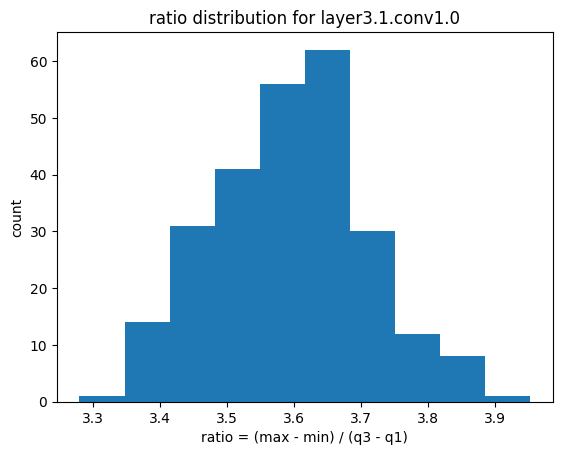

----------------------------------------------------
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 256/256 [00:00<00:00, 1906.41it/s]


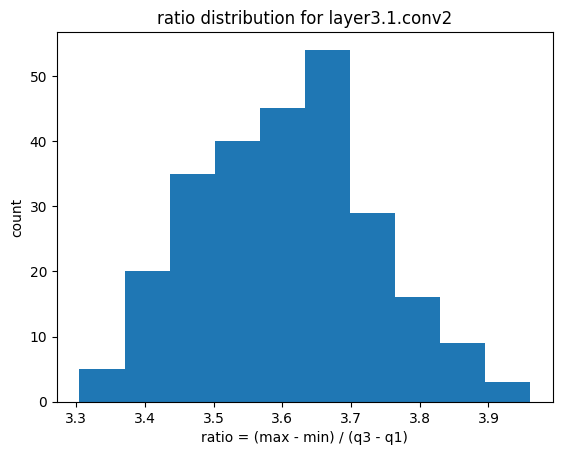

----------------------------------------------------
Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


100%|██████████| 512/512 [00:00<00:00, 1874.28it/s]


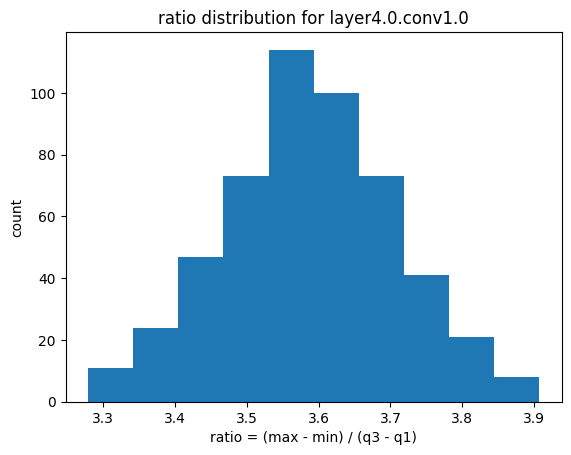

----------------------------------------------------
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 512/512 [00:00<00:00, 1285.55it/s]


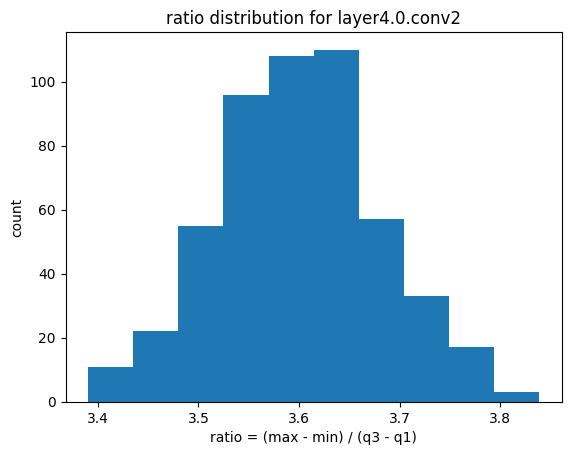

----------------------------------------------------
Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))


100%|██████████| 512/512 [00:00<00:00, 3759.82it/s]


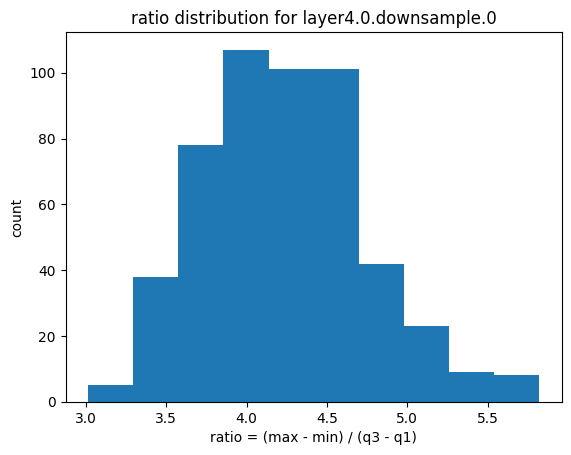

----------------------------------------------------
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 512/512 [00:00<00:00, 1285.94it/s]


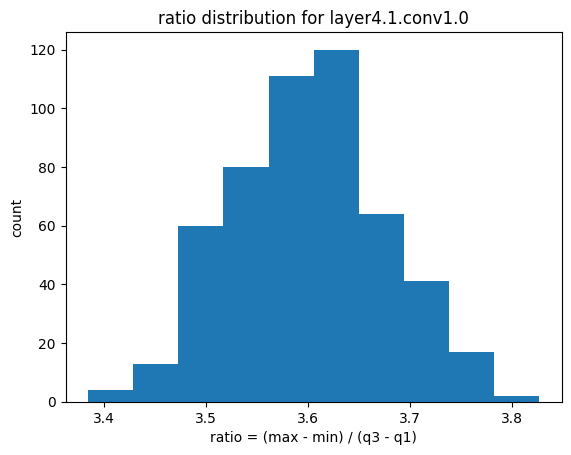

----------------------------------------------------
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 512/512 [00:00<00:00, 1286.88it/s]


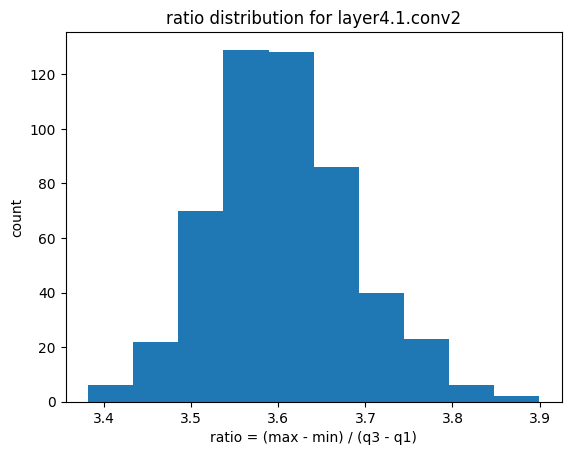

----------------------------------------------------
Linear(in_features=512, out_features=10, bias=True)
Linear layer ((max_val - min_val) / (q3 - q1)) ratio = 3.6307907104492188


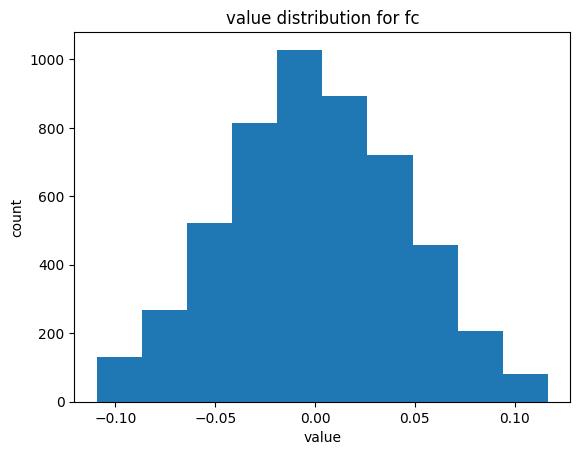

<Figure size 640x480 with 0 Axes>

In [27]:
# plot processed fused model (extreme value being taken out) per_in_channel ratio = (max - min) / (q3 - q1) distribution on the per_out_channel basis for conv modules
wa_quantizer = WeightAwareQuantizer()
# fused_model deepcopied inside
processed_fused_model = wa_quantizer.process_fuse_model(fused_model)
measure_conv_global_stats(processed_fused_model)
measure_linear_stats(processed_fused_model)

# Accuracy & Memory Measurement on:
  - original model / fused model
  - quantized model by pytorch
  - weight aware quantized model by us

## Get quantized models

In [ ]:
quantized_model = QuantizedResNet18(copy.deepcopy(fused_model))
quantization_config = torch.ao.quantization.get_default_qconfig("x86")
quantized_model.qconfig = quantization_config
torch.ao.quantization.prepare(quantized_model, inplace=True)
calibrate_model(model=quantized_model, loader=train_loader, device=cpu_device)
quantized_model = torch.ao.quantization.convert(quantized_model, inplace=True)

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
wa_quantizer_1 = WeightAwareQuantizer()
# fused_model deepcopied inside
processed_fused_model_1 = wa_quantizer_1.process_fuse_model(fused_model)
processed_quantized_model_1 = wa_quantizer_1.optimzied_quantize_with_x86_default(processed_fused_model_1, train_loader, cpu_device)

-----version 2--------
Conv2d with name:  conv1.0


100%|██████████| 64/64 [00:00<00:00, 1712.22it/s]


successfully extract extreme value out from  conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv1.0


100%|██████████| 64/64 [00:00<00:00, 686.36it/s]


successfully extract extreme value out from  layer1.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv2


100%|██████████| 64/64 [00:00<00:00, 634.26it/s]


successfully extract extreme value out from  layer1.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv1.0


100%|██████████| 64/64 [00:00<00:00, 588.01it/s]


successfully extract extreme value out from  layer1.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv2


100%|██████████| 64/64 [00:00<00:00, 587.46it/s]


successfully extract extreme value out from  layer1.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv1.0


100%|██████████| 128/128 [00:00<00:00, 661.91it/s]


successfully extract extreme value out from  layer2.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv2


100%|██████████| 128/128 [00:00<00:00, 371.59it/s]


successfully extract extreme value out from  layer2.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.downsample.0
Conv2d with name:  layer2.1.conv1.0


100%|██████████| 128/128 [00:00<00:00, 366.98it/s]


successfully extract extreme value out from  layer2.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.1.conv2


100%|██████████| 128/128 [00:00<00:00, 368.39it/s]


successfully extract extreme value out from  layer2.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv1.0


100%|██████████| 256/256 [00:00<00:00, 373.36it/s]


successfully extract extreme value out from  layer3.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv2


100%|██████████| 256/256 [00:01<00:00, 206.71it/s]


successfully extract extreme value out from  layer3.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.downsample.0
Conv2d with name:  layer3.1.conv1.0


100%|██████████| 256/256 [00:01<00:00, 200.27it/s]


successfully extract extreme value out from  layer3.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.1.conv2


100%|██████████| 256/256 [00:01<00:00, 186.52it/s]


successfully extract extreme value out from  layer3.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv1.0


100%|██████████| 512/512 [00:03<00:00, 141.88it/s]


successfully extract extreme value out from  layer4.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv2


100%|██████████| 512/512 [00:04<00:00, 107.51it/s]


successfully extract extreme value out from  layer4.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.downsample.0
Conv2d with name:  layer4.1.conv1.0


100%|██████████| 512/512 [00:04<00:00, 102.83it/s]


successfully extract extreme value out from  layer4.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.1.conv2


100%|██████████| 512/512 [00:05<00:00, 88.95it/s] 


successfully extract extreme value out from  layer4.1.conv2  and replace with per in channel mean vals
Linear with name:  fc
successfully extract extreme value out from  fc  and replace with per in channel mean vals
Finish process fused model


/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
wa_quantizer_2 = WeightAwareQuantizer()
processed_fused_model_2 = wa_quantizer_2.process_fuse_model(fused_model)
processed_quantized_model_2 = wa_quantizer_2.optimzied_quantize(processed_fused_model_2, train_loader, cpu_device)

-----version 2--------
Conv2d with name:  conv1.0


100%|██████████| 64/64 [00:00<00:00, 729.66it/s]

successfully extract extreme value out from  conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv1.0



100%|██████████| 64/64 [00:00<00:00, 335.76it/s]


successfully extract extreme value out from  layer1.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv2


100%|██████████| 64/64 [00:00<00:00, 513.12it/s]


successfully extract extreme value out from  layer1.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv1.0


100%|██████████| 64/64 [00:00<00:00, 474.46it/s]


successfully extract extreme value out from  layer1.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv2


100%|██████████| 64/64 [00:00<00:00, 542.82it/s]


successfully extract extreme value out from  layer1.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv1.0


100%|██████████| 128/128 [00:00<00:00, 595.77it/s]


successfully extract extreme value out from  layer2.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv2


100%|██████████| 128/128 [00:00<00:00, 311.67it/s]


successfully extract extreme value out from  layer2.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.downsample.0
Conv2d with name:  layer2.1.conv1.0


100%|██████████| 128/128 [00:00<00:00, 309.67it/s]


successfully extract extreme value out from  layer2.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.1.conv2


100%|██████████| 128/128 [00:00<00:00, 322.42it/s]


successfully extract extreme value out from  layer2.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv1.0


100%|██████████| 256/256 [00:00<00:00, 317.38it/s]


successfully extract extreme value out from  layer3.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv2


100%|██████████| 256/256 [00:01<00:00, 172.19it/s]


successfully extract extreme value out from  layer3.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.downsample.0
Conv2d with name:  layer3.1.conv1.0


100%|██████████| 256/256 [00:01<00:00, 170.92it/s]


successfully extract extreme value out from  layer3.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.1.conv2


100%|██████████| 256/256 [00:01<00:00, 171.47it/s]


successfully extract extreme value out from  layer3.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv1.0


100%|██████████| 512/512 [00:03<00:00, 142.09it/s]


successfully extract extreme value out from  layer4.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv2


100%|██████████| 512/512 [00:06<00:00, 82.32it/s]


successfully extract extreme value out from  layer4.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.downsample.0
Conv2d with name:  layer4.1.conv1.0


100%|██████████| 512/512 [00:05<00:00, 91.09it/s]


successfully extract extreme value out from  layer4.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.1.conv2


100%|██████████| 512/512 [00:06<00:00, 73.86it/s]


successfully extract extreme value out from  layer4.1.conv2  and replace with per in channel mean vals
Linear with name:  fc
successfully extract extreme value out from  fc  and replace with per in channel mean vals
Finish process fused model


/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


## Measurement

### Accuracy & Time

In [ ]:
%%timeit
_, full_eval_accuracy = evaluate_model(model=model, test_loader=test_loader, device=cpu_device, criterion=None)
print(full_eval_accuracy)

tensor(0.7417)
tensor(0.7417)
tensor(0.7417)
tensor(0.7417)
tensor(0.7417)
tensor(0.7417)
tensor(0.7417)
tensor(0.7417)
33.8 s ± 3.78 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
_, fused_eval_accuracy = evaluate_model(model=fused_model, test_loader=test_loader, device=cpu_device, criterion=None)
print(fused_eval_accuracy)

tensor(0.7417)
tensor(0.7417)
tensor(0.7417)
tensor(0.7417)
tensor(0.7417)
tensor(0.7417)
tensor(0.7417)
tensor(0.7417)
30.5 s ± 191 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
_, quantized_eval_accuracy = evaluate_model(model=quantized_model, test_loader=test_loader, device=cpu_device, criterion=None)
print(quantized_eval_accuracy)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor(0.7389)
tensor(0.7389)
tensor(0.7389)
tensor(0.7389)
tensor(0.7389)
tensor(0.7389)
tensor(0.7389)
tensor(0.7389)
14.6 s ± 125 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
_, mixed_eval_accuracy_1 = evaluate_mixed_model(wa_quantizer=wa_quantizer_1, model=processed_quantized_model_1, test_loader=test_loader, device=cpu_device, criterion=None)
print(mixed_eval_accuracy_1)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor(0.7412)
tensor(0.7412)
tensor(0.7412)
tensor(0.7412)
tensor(0.7412)
tensor(0.7412)
tensor(0.7412)
tensor(0.7412)
3min 17s ± 17.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
_, mixed_eval_accuracy_2 = evaluate_mixed_model(wa_quantizer=wa_quantizer_2, model=processed_quantized_model_2, test_loader=test_loader, device=cpu_device, criterion=None)
print(mixed_eval_accuracy_2)

tensor(0.7414)
tensor(0.7414)
tensor(0.7414)
tensor(0.7414)
tensor(0.7414)
tensor(0.7414)
tensor(0.7414)
tensor(0.7414)
2min 47s ± 3.08 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Memmory

#### Model Size

In [ ]:
# 1. full and fused model size

def get_model_size(model):
  param_size = 0
  for param in model.parameters():
      param_size += param.nelement() * param.element_size()
  buffer_size = 0
  for buffer in model.buffers():
      buffer_size += buffer.nelement() * buffer.element_size()

  size_all_mb = (param_size + buffer_size) / 1024**2
  return size_all_mb

model_size = get_model_size(model)
print('model size: {:.9f}MB'.format(model_size))
fused_model_size = get_model_size(fused_model)
print('fused model size: {:.9f}MB'.format(fused_model_size))

model size: 42.691352844MB
fused model size: 42.636268616MB


In [ ]:
# previously saved model .pt also has size 42.7MB, which is close to the above value
# so use the saved model size as an estimate as model size even for quantized model
# to save some unneeded programming efforts (quantized model cannot be read through .parameters())

In [ ]:
# 2. quantized model size
torch.jit.save(torch.jit.script(quantized_model), quantized_model_filepath)

In [ ]:
# by examing the saved file, quantized model has size = 10.8MB

In [ ]:
# 3. overhead introduced by fp32_dict in weight_aware_quantizer
size_in_bytes = 0
for key, val in wa_quantizer_1.fp32_dict.items():
  for in_list in val:
    # for conv2d and linear layer, overhead all 8 bytes per tuple
    size_in_bytes += (len(in_list) * 8)
print('wa quantized fp32_dict has size: {:.3f}MB'.format(size_in_bytes / 1024**2))

wa quantized fp32_dict has size: 1.725MB


In [ ]:
# Improve from 0.7389 -> 0.7414 with 1.725MB overhead
# full model: 42.7MB acc - 0.7417; pytorch quantized model: 10.8MB

#### Peak Memory

In [ ]:
import tracemalloc

In [ ]:
tracemalloc.start()
_, original_eval_accuracy = evaluate_model(model=model, test_loader=test_loader, device=cpu_device, criterion=None)
current, peak =  tracemalloc.get_traced_memory()
print(f"{current/1024:0.2f}KB, {peak/1024:0.2f}KB")
tracemalloc.stop()
print(original_eval_accuracy)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


113.66KB, 261.36KB
tensor(0.7417)


In [ ]:
tracemalloc.start()
_, original_eval_accuracy = evaluate_model(model=fused_model, test_loader=test_loader, device=cpu_device, criterion=None)
current, peak =  tracemalloc.get_traced_memory()
print(f"{current/1024:0.2f}KB, {peak/1024:0.2f}KB")
tracemalloc.stop()
print(original_eval_accuracy)

196.82KB, 823.19KB
tensor(0.7417)


In [ ]:
tracemalloc.start()
_, original_eval_accuracy = evaluate_model(model=quantized_model, test_loader=test_loader, device=cpu_device, criterion=None)
current, peak =  tracemalloc.get_traced_memory()
print(f"{current/1024:0.2f}KB, {peak/1024:0.2f}KB")
tracemalloc.stop()
print(original_eval_accuracy)

119.01KB, 250.35KB
tensor(0.7389)


In [ ]:
tracemalloc.start()
_, mixed_eval_accuracy_1 = evaluate_mixed_model(wa_quantizer=wa_quantizer_1, model=processed_quantized_model_1, test_loader=test_loader, device=cpu_device, criterion=None)
current, peak =  tracemalloc.get_traced_memory()
print(f"{current/1024:0.2f}KB, {peak/1024:0.2f}KB")
tracemalloc.stop()
print(mixed_eval_accuracy_1)

100.10KB, 243.06KB
tensor(0.7412)


In [ ]:
tracemalloc.start()
_, mixed_eval_accuracy_1 = evaluate_mixed_model(wa_quantizer=wa_quantizer_2, model=processed_quantized_model_2, test_loader=test_loader, device=cpu_device, criterion=None)
current, peak =  tracemalloc.get_traced_memory()
print(f"{current/1024:0.2f}KB, {peak/1024:0.2f}KB")
tracemalloc.stop()
print(mixed_eval_accuracy_1)

111.72KB, 251.91KB
tensor(0.7414)


# Accuracy & fp32_dict overhead with different cutoffs
different cutoffs(1,2,3,4,5,variant)

In [29]:
# check full model accuracy are the same (may have diff due to diff cpu)
_, full_eval_accuracy = evaluate_model(model=model, test_loader=test_loader, device=cpu_device, criterion=None)
print(full_eval_accuracy)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor(0.7417)


**note: optimzied_quantize_with_x86_default is used below but not optimzied_quantize**

In [30]:
wa_quantizer_fixed_1 = WeightAwareQuantizer(1, 99, False)
fixed_fused_model_1 = wa_quantizer_fixed_1.process_fuse_model(fused_model)
fixed_quantized_model_1 = wa_quantizer_fixed_1.optimzied_quantize_with_x86_default(fixed_fused_model_1, train_loader, cpu_device)

-----version 2--------
Conv2d with name:  conv1.0


100%|██████████| 64/64 [00:00<00:00, 1086.19it/s]


successfully extract extreme value out from  conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv1.0


100%|██████████| 64/64 [00:00<00:00, 542.61it/s]


successfully extract extreme value out from  layer1.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv2


100%|██████████| 64/64 [00:00<00:00, 587.12it/s]


successfully extract extreme value out from  layer1.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv1.0


100%|██████████| 64/64 [00:00<00:00, 674.08it/s]


successfully extract extreme value out from  layer1.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv2


100%|██████████| 64/64 [00:00<00:00, 671.09it/s]


successfully extract extreme value out from  layer1.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv1.0


100%|██████████| 128/128 [00:00<00:00, 374.60it/s]


successfully extract extreme value out from  layer2.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv2


100%|██████████| 128/128 [00:00<00:00, 226.00it/s]


successfully extract extreme value out from  layer2.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.downsample.0
Conv2d with name:  layer2.1.conv1.0


100%|██████████| 128/128 [00:00<00:00, 265.96it/s]


successfully extract extreme value out from  layer2.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.1.conv2


100%|██████████| 128/128 [00:00<00:00, 229.55it/s]


successfully extract extreme value out from  layer2.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv1.0


100%|██████████| 256/256 [00:01<00:00, 212.89it/s]


successfully extract extreme value out from  layer3.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv2


100%|██████████| 256/256 [00:03<00:00, 78.14it/s]


successfully extract extreme value out from  layer3.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.downsample.0
Conv2d with name:  layer3.1.conv1.0


100%|██████████| 256/256 [00:02<00:00, 106.66it/s]


successfully extract extreme value out from  layer3.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.1.conv2


100%|██████████| 256/256 [00:01<00:00, 143.90it/s]


successfully extract extreme value out from  layer3.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv1.0


100%|██████████| 512/512 [00:03<00:00, 137.88it/s]


successfully extract extreme value out from  layer4.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv2


100%|██████████| 512/512 [00:07<00:00, 70.76it/s] 


successfully extract extreme value out from  layer4.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.downsample.0
Conv2d with name:  layer4.1.conv1.0


100%|██████████| 512/512 [00:05<00:00, 89.63it/s] 


successfully extract extreme value out from  layer4.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.1.conv2


100%|██████████| 512/512 [00:06<00:00, 82.33it/s] 
/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


successfully extract extreme value out from  layer4.1.conv2  and replace with per in channel mean vals
Linear with name:  fc
successfully extract extreme value out from  fc  and replace with per in channel mean vals
Finish process fused model


In [31]:
wa_quantizer_fixed_2 = WeightAwareQuantizer(2, 98, False)
fixed_fused_model_2 = wa_quantizer_fixed_2.process_fuse_model(fused_model)
fixed_quantized_model_2 = wa_quantizer_fixed_2.optimzied_quantize_with_x86_default(fixed_fused_model_2, train_loader, cpu_device)

-----version 2--------
Conv2d with name:  conv1.0


100%|██████████| 64/64 [00:00<00:00, 1135.97it/s]


successfully extract extreme value out from  conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv1.0


100%|██████████| 64/64 [00:00<00:00, 351.10it/s]


successfully extract extreme value out from  layer1.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv2


100%|██████████| 64/64 [00:00<00:00, 346.00it/s]


successfully extract extreme value out from  layer1.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv1.0


100%|██████████| 64/64 [00:00<00:00, 358.92it/s]


successfully extract extreme value out from  layer1.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv2


100%|██████████| 64/64 [00:00<00:00, 370.59it/s]


successfully extract extreme value out from  layer1.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv1.0


100%|██████████| 128/128 [00:00<00:00, 347.08it/s]


successfully extract extreme value out from  layer2.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv2


100%|██████████| 128/128 [00:00<00:00, 197.22it/s]


successfully extract extreme value out from  layer2.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.downsample.0
Conv2d with name:  layer2.1.conv1.0


100%|██████████| 128/128 [00:00<00:00, 190.97it/s]


successfully extract extreme value out from  layer2.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.1.conv2


100%|██████████| 128/128 [00:00<00:00, 204.49it/s]


successfully extract extreme value out from  layer2.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv1.0


100%|██████████| 256/256 [00:01<00:00, 196.24it/s]


successfully extract extreme value out from  layer3.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv2


100%|██████████| 256/256 [00:02<00:00, 107.26it/s]


successfully extract extreme value out from  layer3.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.downsample.0
Conv2d with name:  layer3.1.conv1.0


100%|██████████| 256/256 [00:03<00:00, 84.62it/s]


successfully extract extreme value out from  layer3.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.1.conv2


100%|██████████| 256/256 [00:03<00:00, 78.96it/s] 


successfully extract extreme value out from  layer3.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv1.0


100%|██████████| 512/512 [00:04<00:00, 108.77it/s]


successfully extract extreme value out from  layer4.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv2


100%|██████████| 512/512 [00:10<00:00, 49.26it/s]


successfully extract extreme value out from  layer4.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.downsample.0
Conv2d with name:  layer4.1.conv1.0


100%|██████████| 512/512 [00:09<00:00, 51.81it/s]


successfully extract extreme value out from  layer4.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.1.conv2


100%|██████████| 512/512 [00:10<00:00, 50.08it/s]


successfully extract extreme value out from  layer4.1.conv2  and replace with per in channel mean vals
Linear with name:  fc
successfully extract extreme value out from  fc  and replace with per in channel mean vals
Finish process fused model


In [32]:
wa_quantizer_fixed_3 = WeightAwareQuantizer(3, 97, False)
fixed_fused_model_3 = wa_quantizer_fixed_3.process_fuse_model(fused_model)
fixed_quantized_model_3 = wa_quantizer_fixed_3.optimzied_quantize_with_x86_default(fixed_fused_model_3, train_loader, cpu_device)

-----version 2--------
Conv2d with name:  conv1.0


100%|██████████| 64/64 [00:00<00:00, 812.82it/s]


successfully extract extreme value out from  conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv1.0


100%|██████████| 64/64 [00:00<00:00, 250.50it/s]


successfully extract extreme value out from  layer1.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv2


100%|██████████| 64/64 [00:00<00:00, 196.07it/s]


successfully extract extreme value out from  layer1.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv1.0


100%|██████████| 64/64 [00:00<00:00, 255.83it/s]


successfully extract extreme value out from  layer1.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv2


100%|██████████| 64/64 [00:00<00:00, 252.09it/s]


successfully extract extreme value out from  layer1.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv1.0


100%|██████████| 128/128 [00:00<00:00, 263.17it/s]


successfully extract extreme value out from  layer2.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv2


100%|██████████| 128/128 [00:00<00:00, 142.31it/s]


successfully extract extreme value out from  layer2.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.downsample.0
Conv2d with name:  layer2.1.conv1.0


100%|██████████| 128/128 [00:00<00:00, 139.82it/s]


successfully extract extreme value out from  layer2.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.1.conv2


100%|██████████| 128/128 [00:00<00:00, 139.93it/s]


successfully extract extreme value out from  layer2.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv1.0


100%|██████████| 256/256 [00:01<00:00, 143.17it/s]


successfully extract extreme value out from  layer3.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv2


100%|██████████| 256/256 [00:04<00:00, 63.80it/s]


successfully extract extreme value out from  layer3.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.downsample.0
Conv2d with name:  layer3.1.conv1.0


100%|██████████| 256/256 [00:04<00:00, 59.47it/s]


successfully extract extreme value out from  layer3.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.1.conv2


100%|██████████| 256/256 [00:03<00:00, 70.57it/s]


successfully extract extreme value out from  layer3.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv1.0


100%|██████████| 512/512 [00:08<00:00, 60.34it/s]


successfully extract extreme value out from  layer4.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv2


100%|██████████| 512/512 [00:14<00:00, 34.63it/s]


successfully extract extreme value out from  layer4.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.downsample.0
Conv2d with name:  layer4.1.conv1.0


100%|██████████| 512/512 [00:15<00:00, 34.09it/s]


successfully extract extreme value out from  layer4.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.1.conv2


100%|██████████| 512/512 [00:14<00:00, 34.83it/s]


successfully extract extreme value out from  layer4.1.conv2  and replace with per in channel mean vals
Linear with name:  fc
successfully extract extreme value out from  fc  and replace with per in channel mean vals
Finish process fused model


In [33]:
wa_quantizer_fixed_4 = WeightAwareQuantizer(4, 96, False)
fixed_fused_model_4 = wa_quantizer_fixed_4.process_fuse_model(fused_model)
fixed_quantized_model_4 = wa_quantizer_fixed_4.optimzied_quantize_with_x86_default(fixed_fused_model_4, train_loader, cpu_device)

-----version 2--------
Conv2d with name:  conv1.0


100%|██████████| 64/64 [00:00<00:00, 741.43it/s]


successfully extract extreme value out from  conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv1.0


100%|██████████| 64/64 [00:00<00:00, 185.44it/s]


successfully extract extreme value out from  layer1.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv2


100%|██████████| 64/64 [00:00<00:00, 139.50it/s]


successfully extract extreme value out from  layer1.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv1.0


100%|██████████| 64/64 [00:00<00:00, 149.17it/s]


successfully extract extreme value out from  layer1.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv2


100%|██████████| 64/64 [00:00<00:00, 149.17it/s]


successfully extract extreme value out from  layer1.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv1.0


100%|██████████| 128/128 [00:00<00:00, 145.46it/s]


successfully extract extreme value out from  layer2.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv2


100%|██████████| 128/128 [00:01<00:00, 70.00it/s]


successfully extract extreme value out from  layer2.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.downsample.0
Conv2d with name:  layer2.1.conv1.0


100%|██████████| 128/128 [00:01<00:00, 107.72it/s]


successfully extract extreme value out from  layer2.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.1.conv2


100%|██████████| 128/128 [00:01<00:00, 107.84it/s]


successfully extract extreme value out from  layer2.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv1.0


100%|██████████| 256/256 [00:02<00:00, 105.53it/s]


successfully extract extreme value out from  layer3.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv2


100%|██████████| 256/256 [00:04<00:00, 56.21it/s]


successfully extract extreme value out from  layer3.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.downsample.0
Conv2d with name:  layer3.1.conv1.0


100%|██████████| 256/256 [00:05<00:00, 43.57it/s]


successfully extract extreme value out from  layer3.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.1.conv2


100%|██████████| 256/256 [00:04<00:00, 56.59it/s]


successfully extract extreme value out from  layer3.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv1.0


100%|██████████| 512/512 [00:10<00:00, 49.35it/s]


successfully extract extreme value out from  layer4.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv2


100%|██████████| 512/512 [00:19<00:00, 26.61it/s]


successfully extract extreme value out from  layer4.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.downsample.0
Conv2d with name:  layer4.1.conv1.0


100%|██████████| 512/512 [00:20<00:00, 25.03it/s]


successfully extract extreme value out from  layer4.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.1.conv2


100%|██████████| 512/512 [00:19<00:00, 26.42it/s]


successfully extract extreme value out from  layer4.1.conv2  and replace with per in channel mean vals
Linear with name:  fc
successfully extract extreme value out from  fc  and replace with per in channel mean vals
Finish process fused model


In [34]:
wa_quantizer_fixed_5 = WeightAwareQuantizer(5, 95, False)
fixed_fused_model_5 = wa_quantizer_fixed_5.process_fuse_model(fused_model)
fixed_quantized_model_5 = wa_quantizer_fixed_5.optimzied_quantize_with_x86_default(fixed_fused_model_5, train_loader, cpu_device)

-----version 2--------
Conv2d with name:  conv1.0


100%|██████████| 64/64 [00:00<00:00, 545.63it/s]


successfully extract extreme value out from  conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv1.0


100%|██████████| 64/64 [00:00<00:00, 172.27it/s]


successfully extract extreme value out from  layer1.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv2


100%|██████████| 64/64 [00:00<00:00, 134.72it/s]


successfully extract extreme value out from  layer1.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv1.0


100%|██████████| 64/64 [00:00<00:00, 166.62it/s]


successfully extract extreme value out from  layer1.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv2


100%|██████████| 64/64 [00:00<00:00, 172.35it/s]


successfully extract extreme value out from  layer1.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv1.0


100%|██████████| 128/128 [00:00<00:00, 169.19it/s]


successfully extract extreme value out from  layer2.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv2


100%|██████████| 128/128 [00:01<00:00, 89.85it/s]


successfully extract extreme value out from  layer2.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.downsample.0
Conv2d with name:  layer2.1.conv1.0


100%|██████████| 128/128 [00:01<00:00, 90.04it/s]


successfully extract extreme value out from  layer2.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.1.conv2


100%|██████████| 128/128 [00:01<00:00, 83.28it/s]


successfully extract extreme value out from  layer2.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv1.0


100%|██████████| 256/256 [00:03<00:00, 72.00it/s]


successfully extract extreme value out from  layer3.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv2


100%|██████████| 256/256 [00:06<00:00, 41.48it/s]


successfully extract extreme value out from  layer3.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.downsample.0
Conv2d with name:  layer3.1.conv1.0


100%|██████████| 256/256 [00:05<00:00, 45.53it/s]


successfully extract extreme value out from  layer3.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.1.conv2


100%|██████████| 256/256 [00:06<00:00, 36.61it/s]


successfully extract extreme value out from  layer3.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv1.0


100%|██████████| 512/512 [00:12<00:00, 40.41it/s]


successfully extract extreme value out from  layer4.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv2


100%|██████████| 512/512 [00:24<00:00, 21.20it/s]


successfully extract extreme value out from  layer4.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.downsample.0
Conv2d with name:  layer4.1.conv1.0


100%|██████████| 512/512 [00:23<00:00, 21.63it/s]


successfully extract extreme value out from  layer4.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.1.conv2


100%|██████████| 512/512 [00:27<00:00, 18.91it/s]


successfully extract extreme value out from  layer4.1.conv2  and replace with per in channel mean vals
Linear with name:  fc
successfully extract extreme value out from  fc  and replace with per in channel mean vals
Finish process fused model


In [35]:
# _"5" means the cutoff_low_end for WeightAwareQuantizer
wa_quantizer_variant_5 = WeightAwareQuantizer(5, 95, True)
variant_fused_model_5 = wa_quantizer_variant_5.process_fuse_model(fused_model)
variant_quantized_model_5 = wa_quantizer_variant_5.optimzied_quantize_with_x86_default(variant_fused_model_5, train_loader, cpu_device)

-----version 2--------
Conv2d with name:  conv1.0


100%|██████████| 64/64 [00:00<00:00, 924.55it/s]


successfully extract extreme value out from  conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv1.0


100%|██████████| 64/64 [00:00<00:00, 224.58it/s]


successfully extract extreme value out from  layer1.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv2


100%|██████████| 64/64 [00:00<00:00, 231.76it/s]


successfully extract extreme value out from  layer1.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv1.0


100%|██████████| 64/64 [00:00<00:00, 235.18it/s]


successfully extract extreme value out from  layer1.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv2


100%|██████████| 64/64 [00:00<00:00, 242.02it/s]


successfully extract extreme value out from  layer1.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv1.0


100%|██████████| 128/128 [00:00<00:00, 226.92it/s]


successfully extract extreme value out from  layer2.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv2


100%|██████████| 128/128 [00:01<00:00, 120.49it/s]


successfully extract extreme value out from  layer2.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.downsample.0
Conv2d with name:  layer2.1.conv1.0


100%|██████████| 128/128 [00:01<00:00, 123.88it/s]


successfully extract extreme value out from  layer2.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.1.conv2


100%|██████████| 128/128 [00:01<00:00, 118.10it/s]


successfully extract extreme value out from  layer2.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv1.0


100%|██████████| 256/256 [00:02<00:00, 113.93it/s]


successfully extract extreme value out from  layer3.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv2


100%|██████████| 256/256 [00:05<00:00, 45.58it/s]


successfully extract extreme value out from  layer3.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.downsample.0
Conv2d with name:  layer3.1.conv1.0


100%|██████████| 256/256 [00:04<00:00, 58.04it/s]


successfully extract extreme value out from  layer3.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.1.conv2


100%|██████████| 256/256 [00:04<00:00, 59.31it/s]


successfully extract extreme value out from  layer3.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv1.0


100%|██████████| 512/512 [00:09<00:00, 51.40it/s]


successfully extract extreme value out from  layer4.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv2


100%|██████████| 512/512 [00:18<00:00, 27.65it/s]


successfully extract extreme value out from  layer4.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.downsample.0
Conv2d with name:  layer4.1.conv1.0


100%|██████████| 512/512 [00:19<00:00, 26.45it/s]


successfully extract extreme value out from  layer4.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.1.conv2


100%|██████████| 512/512 [00:18<00:00, 27.52it/s]


successfully extract extreme value out from  layer4.1.conv2  and replace with per in channel mean vals
Linear with name:  fc
successfully extract extreme value out from  fc  and replace with per in channel mean vals
Finish process fused model


In [36]:
def get_fp32_dict_size(wa_quantizer_arg):
  size_in_bytes = 0
  for key, val in wa_quantizer_arg.fp32_dict.items():
    for in_list in val:
      # for conv2d and linear layer, overhead all 8 bytes per tuple
      size_in_bytes += (len(in_list) * 8)
  print("---------------------------------------------------")
  print('wa quantized fp32_dict has size: {:.3f}MB'.format(size_in_bytes / 1024**2))

In [40]:
get_fp32_dict_size(wa_quantizer_fixed_1)
get_fp32_dict_size(wa_quantizer_fixed_2)
get_fp32_dict_size(wa_quantizer_fixed_3)
get_fp32_dict_size(wa_quantizer_fixed_4)
get_fp32_dict_size(wa_quantizer_fixed_5)
get_fp32_dict_size(wa_quantizer_variant_5)
# see prev experiments (wa_quantizer_1) for wa_quantizer_variant_2 - default setting for weight_awarez_quantizer
# which has size 1.725MB

---------------------------------------------------
wa quantized fp32_dict has size: 1.727MB
---------------------------------------------------
wa quantized fp32_dict has size: 3.410MB
---------------------------------------------------
wa quantized fp32_dict has size: 5.084MB
---------------------------------------------------
wa quantized fp32_dict has size: 6.761MB
---------------------------------------------------
wa quantized fp32_dict has size: 8.436MB
---------------------------------------------------
wa quantized fp32_dict has size: 6.471MB


In [41]:
%%timeit
_, fixed_1_eval_accuracy = evaluate_mixed_model(wa_quantizer=wa_quantizer_fixed_1, model=fixed_quantized_model_1, test_loader=test_loader, device=cpu_device, criterion=None)
print(fixed_1_eval_accuracy)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor(0.7409)
tensor(0.7409)
tensor(0.7409)
tensor(0.7409)
tensor(0.7409)
tensor(0.7409)
tensor(0.7409)
tensor(0.7409)
3min 8s ± 1.61 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%%timeit
_, fixed_2_eval_accuracy = evaluate_mixed_model(wa_quantizer=wa_quantizer_fixed_2, model=fixed_quantized_model_2, test_loader=test_loader, device=cpu_device, criterion=None)
print(fixed_2_eval_accuracy)

tensor(0.7416)
tensor(0.7416)
tensor(0.7416)
tensor(0.7416)
tensor(0.7416)
tensor(0.7416)
tensor(0.7416)
tensor(0.7416)
5min 40s ± 1.36 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
%%timeit
_, fixed_3_eval_accuracy = evaluate_mixed_model(wa_quantizer=wa_quantizer_fixed_3, model=fixed_quantized_model_3, test_loader=test_loader, device=cpu_device, criterion=None)
print(fixed_3_eval_accuracy)

tensor(0.7416)
tensor(0.7416)
tensor(0.7416)
tensor(0.7416)
tensor(0.7416)
tensor(0.7416)
tensor(0.7416)
tensor(0.7416)
8min 24s ± 31.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
_, fixed_4_eval_accuracy = evaluate_mixed_model(wa_quantizer=wa_quantizer_fixed_4, model=fixed_quantized_model_4, test_loader=test_loader, device=cpu_device, criterion=None)
print(fixed_4_eval_accuracy)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor(0.7419)


In [46]:
_, fixed_5_eval_accuracy = evaluate_mixed_model(wa_quantizer=wa_quantizer_fixed_5, model=fixed_quantized_model_5, test_loader=test_loader, device=cpu_device, criterion=None)
print(fixed_5_eval_accuracy)

tensor(0.7411)


In [47]:
_, variant_5_eval_accuracy = evaluate_mixed_model(wa_quantizer=wa_quantizer_variant_5, model=variant_quantized_model_5, test_loader=test_loader, device=cpu_device, criterion=None)
print(variant_5_eval_accuracy)

tensor(0.7410)


**note: optimzied_quantize is used below but not optimzied_quantize_with_x86_default**

In [49]:
wa_quantizer_fixed_21 = WeightAwareQuantizer(1, 99, False)
fixed_fused_model_21 = wa_quantizer_fixed_21.process_fuse_model(fused_model)
fixed_quantized_model_21 = wa_quantizer_fixed_21.optimzied_quantize(fixed_fused_model_21, train_loader, cpu_device)
wa_quantizer_fixed_22 = WeightAwareQuantizer(2, 98, False)
fixed_fused_model_22 = wa_quantizer_fixed_22.process_fuse_model(fused_model)
fixed_quantized_model_22 = wa_quantizer_fixed_22.optimzied_quantize(fixed_fused_model_22, train_loader, cpu_device)
wa_quantizer_fixed_23 = WeightAwareQuantizer(3, 97, False)
fixed_fused_model_23 = wa_quantizer_fixed_23.process_fuse_model(fused_model)
fixed_quantized_model_23 = wa_quantizer_fixed_23.optimzied_quantize(fixed_fused_model_23, train_loader, cpu_device)
wa_quantizer_fixed_24 = WeightAwareQuantizer(4, 96, False)
fixed_fused_model_24 = wa_quantizer_fixed_24.process_fuse_model(fused_model)
fixed_quantized_model_24 = wa_quantizer_fixed_24.optimzied_quantize(fixed_fused_model_24, train_loader, cpu_device)
wa_quantizer_fixed_25 = WeightAwareQuantizer(5, 95, False)
fixed_fused_model_25 = wa_quantizer_fixed_25.process_fuse_model(fused_model)
fixed_quantized_model_25 = wa_quantizer_fixed_25.optimzied_quantize(fixed_fused_model_25, train_loader, cpu_device)
wa_quantizer_variant_25 = WeightAwareQuantizer(5, 95, True)
variant_fused_model_25 = wa_quantizer_variant_25.process_fuse_model(fused_model)
variant_quantized_model_25 = wa_quantizer_variant_25.optimzied_quantize(variant_fused_model_25, train_loader, cpu_device)

-----version 2--------
Conv2d with name:  conv1.0


100%|██████████| 64/64 [00:00<00:00, 1392.31it/s]


successfully extract extreme value out from  conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv1.0


100%|██████████| 64/64 [00:00<00:00, 396.27it/s]


successfully extract extreme value out from  layer1.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv2


100%|██████████| 64/64 [00:00<00:00, 527.55it/s]


successfully extract extreme value out from  layer1.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv1.0


100%|██████████| 64/64 [00:00<00:00, 578.45it/s]


successfully extract extreme value out from  layer1.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv2


100%|██████████| 64/64 [00:00<00:00, 392.51it/s]


successfully extract extreme value out from  layer1.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv1.0


100%|██████████| 128/128 [00:00<00:00, 552.71it/s]


successfully extract extreme value out from  layer2.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv2


100%|██████████| 128/128 [00:00<00:00, 347.89it/s]


successfully extract extreme value out from  layer2.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.downsample.0
Conv2d with name:  layer2.1.conv1.0


100%|██████████| 128/128 [00:00<00:00, 362.91it/s]


successfully extract extreme value out from  layer2.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.1.conv2


100%|██████████| 128/128 [00:00<00:00, 349.13it/s]


successfully extract extreme value out from  layer2.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv1.0


100%|██████████| 256/256 [00:00<00:00, 355.99it/s]


successfully extract extreme value out from  layer3.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv2


100%|██████████| 256/256 [00:01<00:00, 173.00it/s]


successfully extract extreme value out from  layer3.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.downsample.0
Conv2d with name:  layer3.1.conv1.0


100%|██████████| 256/256 [00:02<00:00, 125.97it/s]


successfully extract extreme value out from  layer3.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.1.conv2


100%|██████████| 256/256 [00:02<00:00, 124.07it/s]


successfully extract extreme value out from  layer3.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv1.0


100%|██████████| 512/512 [00:02<00:00, 180.83it/s]


successfully extract extreme value out from  layer4.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv2


100%|██████████| 512/512 [00:05<00:00, 97.94it/s]


successfully extract extreme value out from  layer4.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.downsample.0
Conv2d with name:  layer4.1.conv1.0


100%|██████████| 512/512 [00:06<00:00, 74.93it/s]


successfully extract extreme value out from  layer4.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.1.conv2


100%|██████████| 512/512 [00:06<00:00, 77.84it/s]


successfully extract extreme value out from  layer4.1.conv2  and replace with per in channel mean vals
Linear with name:  fc
successfully extract extreme value out from  fc  and replace with per in channel mean vals
Finish process fused model
-----version 2--------
Conv2d with name:  conv1.0


100%|██████████| 64/64 [00:00<00:00, 423.79it/s]


successfully extract extreme value out from  conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv1.0


100%|██████████| 64/64 [00:00<00:00, 361.97it/s]


successfully extract extreme value out from  layer1.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv2


100%|██████████| 64/64 [00:00<00:00, 348.04it/s]


successfully extract extreme value out from  layer1.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv1.0


100%|██████████| 64/64 [00:00<00:00, 356.22it/s]


successfully extract extreme value out from  layer1.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv2


100%|██████████| 64/64 [00:00<00:00, 359.03it/s]


successfully extract extreme value out from  layer1.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv1.0


100%|██████████| 128/128 [00:00<00:00, 277.78it/s]


successfully extract extreme value out from  layer2.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv2


100%|██████████| 128/128 [00:00<00:00, 130.83it/s]


successfully extract extreme value out from  layer2.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.downsample.0
Conv2d with name:  layer2.1.conv1.0


100%|██████████| 128/128 [00:01<00:00, 126.07it/s]


successfully extract extreme value out from  layer2.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.1.conv2


100%|██████████| 128/128 [00:01<00:00, 115.09it/s]


successfully extract extreme value out from  layer2.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv1.0


100%|██████████| 256/256 [00:01<00:00, 153.02it/s]


successfully extract extreme value out from  layer3.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv2


100%|██████████| 256/256 [00:02<00:00, 97.95it/s] 


successfully extract extreme value out from  layer3.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.downsample.0
Conv2d with name:  layer3.1.conv1.0


100%|██████████| 256/256 [00:02<00:00, 100.99it/s]


successfully extract extreme value out from  layer3.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.1.conv2


100%|██████████| 256/256 [00:02<00:00, 102.46it/s]


successfully extract extreme value out from  layer3.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv1.0


100%|██████████| 512/512 [00:06<00:00, 78.58it/s]


successfully extract extreme value out from  layer4.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv2


100%|██████████| 512/512 [00:10<00:00, 48.32it/s]


successfully extract extreme value out from  layer4.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.downsample.0
Conv2d with name:  layer4.1.conv1.0


100%|██████████| 512/512 [00:11<00:00, 44.60it/s]


successfully extract extreme value out from  layer4.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.1.conv2


100%|██████████| 512/512 [00:11<00:00, 44.02it/s]


successfully extract extreme value out from  layer4.1.conv2  and replace with per in channel mean vals
Linear with name:  fc
successfully extract extreme value out from  fc  and replace with per in channel mean vals
Finish process fused model
-----version 2--------
Conv2d with name:  conv1.0


100%|██████████| 64/64 [00:00<00:00, 313.63it/s]


successfully extract extreme value out from  conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv1.0


100%|██████████| 64/64 [00:00<00:00, 239.59it/s]


successfully extract extreme value out from  layer1.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv2


100%|██████████| 64/64 [00:00<00:00, 230.70it/s]


successfully extract extreme value out from  layer1.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv1.0


100%|██████████| 64/64 [00:00<00:00, 260.41it/s]


successfully extract extreme value out from  layer1.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv2


100%|██████████| 64/64 [00:00<00:00, 255.18it/s]


successfully extract extreme value out from  layer1.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv1.0


100%|██████████| 128/128 [00:00<00:00, 229.22it/s]


successfully extract extreme value out from  layer2.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv2


100%|██████████| 128/128 [00:01<00:00, 127.75it/s]


successfully extract extreme value out from  layer2.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.downsample.0
Conv2d with name:  layer2.1.conv1.0


100%|██████████| 128/128 [00:01<00:00, 123.30it/s]


successfully extract extreme value out from  layer2.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.1.conv2


100%|██████████| 128/128 [00:00<00:00, 129.64it/s]


successfully extract extreme value out from  layer2.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv1.0


100%|██████████| 256/256 [00:02<00:00, 103.73it/s]


successfully extract extreme value out from  layer3.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv2


100%|██████████| 256/256 [00:04<00:00, 58.14it/s]


successfully extract extreme value out from  layer3.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.downsample.0
Conv2d with name:  layer3.1.conv1.0


100%|██████████| 256/256 [00:03<00:00, 70.85it/s]


successfully extract extreme value out from  layer3.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.1.conv2


100%|██████████| 256/256 [00:03<00:00, 69.87it/s]


successfully extract extreme value out from  layer3.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv1.0


100%|██████████| 512/512 [00:08<00:00, 60.00it/s]


successfully extract extreme value out from  layer4.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv2


100%|██████████| 512/512 [00:17<00:00, 29.74it/s]


successfully extract extreme value out from  layer4.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.downsample.0
Conv2d with name:  layer4.1.conv1.0


100%|██████████| 512/512 [00:15<00:00, 32.58it/s]


successfully extract extreme value out from  layer4.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.1.conv2


100%|██████████| 512/512 [00:15<00:00, 32.28it/s]


successfully extract extreme value out from  layer4.1.conv2  and replace with per in channel mean vals
Linear with name:  fc
successfully extract extreme value out from  fc  and replace with per in channel mean vals
Finish process fused model
-----version 2--------
Conv2d with name:  conv1.0


100%|██████████| 64/64 [00:00<00:00, 248.71it/s]


successfully extract extreme value out from  conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv1.0


100%|██████████| 64/64 [00:00<00:00, 190.28it/s]


successfully extract extreme value out from  layer1.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv2


100%|██████████| 64/64 [00:00<00:00, 205.40it/s]


successfully extract extreme value out from  layer1.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv1.0


100%|██████████| 64/64 [00:00<00:00, 200.93it/s]


successfully extract extreme value out from  layer1.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv2


100%|██████████| 64/64 [00:00<00:00, 182.39it/s]


successfully extract extreme value out from  layer1.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv1.0


100%|██████████| 128/128 [00:01<00:00, 94.44it/s] 


successfully extract extreme value out from  layer2.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv2


100%|██████████| 128/128 [00:01<00:00, 99.80it/s] 


successfully extract extreme value out from  layer2.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.downsample.0
Conv2d with name:  layer2.1.conv1.0


100%|██████████| 128/128 [00:01<00:00, 66.01it/s]


successfully extract extreme value out from  layer2.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.1.conv2


100%|██████████| 128/128 [00:02<00:00, 57.53it/s]


successfully extract extreme value out from  layer2.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv1.0


100%|██████████| 256/256 [00:03<00:00, 65.81it/s] 


successfully extract extreme value out from  layer3.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv2


100%|██████████| 256/256 [00:04<00:00, 51.88it/s]


successfully extract extreme value out from  layer3.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.downsample.0
Conv2d with name:  layer3.1.conv1.0


100%|██████████| 256/256 [00:05<00:00, 48.43it/s]


successfully extract extreme value out from  layer3.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.1.conv2


100%|██████████| 256/256 [00:05<00:00, 45.65it/s]


successfully extract extreme value out from  layer3.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv1.0


100%|██████████| 512/512 [00:10<00:00, 47.17it/s]


successfully extract extreme value out from  layer4.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv2


100%|██████████| 512/512 [00:20<00:00, 24.72it/s]


successfully extract extreme value out from  layer4.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.downsample.0
Conv2d with name:  layer4.1.conv1.0


100%|██████████| 512/512 [00:22<00:00, 22.88it/s]


successfully extract extreme value out from  layer4.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.1.conv2


100%|██████████| 512/512 [00:21<00:00, 24.08it/s]


successfully extract extreme value out from  layer4.1.conv2  and replace with per in channel mean vals
Linear with name:  fc
successfully extract extreme value out from  fc  and replace with per in channel mean vals
Finish process fused model
-----version 2--------
Conv2d with name:  conv1.0


100%|██████████| 64/64 [00:00<00:00, 194.09it/s]


successfully extract extreme value out from  conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv1.0


100%|██████████| 64/64 [00:00<00:00, 166.48it/s]


successfully extract extreme value out from  layer1.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv2


100%|██████████| 64/64 [00:00<00:00, 144.94it/s]


successfully extract extreme value out from  layer1.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv1.0


100%|██████████| 64/64 [00:00<00:00, 147.91it/s]


successfully extract extreme value out from  layer1.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv2


100%|██████████| 64/64 [00:00<00:00, 103.25it/s]


successfully extract extreme value out from  layer1.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv1.0


100%|██████████| 128/128 [00:01<00:00, 102.57it/s]


successfully extract extreme value out from  layer2.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv2


100%|██████████| 128/128 [00:02<00:00, 53.84it/s]


successfully extract extreme value out from  layer2.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.downsample.0
Conv2d with name:  layer2.1.conv1.0


100%|██████████| 128/128 [00:01<00:00, 80.92it/s]


successfully extract extreme value out from  layer2.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.1.conv2


100%|██████████| 128/128 [00:01<00:00, 80.98it/s]


successfully extract extreme value out from  layer2.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv1.0


100%|██████████| 256/256 [00:03<00:00, 77.67it/s]


successfully extract extreme value out from  layer3.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv2


100%|██████████| 256/256 [00:07<00:00, 34.84it/s]


successfully extract extreme value out from  layer3.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.downsample.0
Conv2d with name:  layer3.1.conv1.0


100%|██████████| 256/256 [00:06<00:00, 42.38it/s]


successfully extract extreme value out from  layer3.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.1.conv2


100%|██████████| 256/256 [00:07<00:00, 34.32it/s]


successfully extract extreme value out from  layer3.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv1.0


100%|██████████| 512/512 [00:13<00:00, 37.25it/s]


successfully extract extreme value out from  layer4.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv2


100%|██████████| 512/512 [00:27<00:00, 18.59it/s]


successfully extract extreme value out from  layer4.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.downsample.0
Conv2d with name:  layer4.1.conv1.0


100%|██████████| 512/512 [00:27<00:00, 18.50it/s]


successfully extract extreme value out from  layer4.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.1.conv2


100%|██████████| 512/512 [00:28<00:00, 17.89it/s]


successfully extract extreme value out from  layer4.1.conv2  and replace with per in channel mean vals
Linear with name:  fc
successfully extract extreme value out from  fc  and replace with per in channel mean vals
Finish process fused model
-----version 2--------
Conv2d with name:  conv1.0


100%|██████████| 64/64 [00:00<00:00, 794.70it/s]


successfully extract extreme value out from  conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv1.0


100%|██████████| 64/64 [00:00<00:00, 218.00it/s]


successfully extract extreme value out from  layer1.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.0.conv2


100%|██████████| 64/64 [00:00<00:00, 208.63it/s]


successfully extract extreme value out from  layer1.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv1.0


100%|██████████| 64/64 [00:00<00:00, 211.51it/s]


successfully extract extreme value out from  layer1.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer1.1.conv2


100%|██████████| 64/64 [00:00<00:00, 209.60it/s]


successfully extract extreme value out from  layer1.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv1.0


100%|██████████| 128/128 [00:00<00:00, 199.03it/s]


successfully extract extreme value out from  layer2.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.0.conv2


100%|██████████| 128/128 [00:01<00:00, 98.44it/s] 


successfully extract extreme value out from  layer2.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer2.0.downsample.0
Conv2d with name:  layer2.1.conv1.0


100%|██████████| 128/128 [00:01<00:00, 106.79it/s]


successfully extract extreme value out from  layer2.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer2.1.conv2


100%|██████████| 128/128 [00:01<00:00, 106.09it/s]


successfully extract extreme value out from  layer2.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv1.0


100%|██████████| 256/256 [00:02<00:00, 105.24it/s]


successfully extract extreme value out from  layer3.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.0.conv2


100%|██████████| 256/256 [00:06<00:00, 42.31it/s]


successfully extract extreme value out from  layer3.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer3.0.downsample.0
Conv2d with name:  layer3.1.conv1.0


100%|██████████| 256/256 [00:04<00:00, 55.32it/s]


successfully extract extreme value out from  layer3.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer3.1.conv2


100%|██████████| 256/256 [00:05<00:00, 48.37it/s]


successfully extract extreme value out from  layer3.1.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv1.0


100%|██████████| 512/512 [00:09<00:00, 53.14it/s]


successfully extract extreme value out from  layer4.0.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.0.conv2


100%|██████████| 512/512 [00:20<00:00, 24.88it/s]


successfully extract extreme value out from  layer4.0.conv2  and replace with per in channel mean vals
Conv2d with name:  layer4.0.downsample.0
Conv2d with name:  layer4.1.conv1.0


100%|██████████| 512/512 [00:20<00:00, 25.30it/s]


successfully extract extreme value out from  layer4.1.conv1  and replace with per in channel mean vals
Conv2d with name:  layer4.1.conv2


100%|██████████| 512/512 [00:22<00:00, 23.16it/s]


successfully extract extreme value out from  layer4.1.conv2  and replace with per in channel mean vals
Linear with name:  fc
successfully extract extreme value out from  fc  and replace with per in channel mean vals
Finish process fused model


In [50]:
get_fp32_dict_size(wa_quantizer_fixed_21)
get_fp32_dict_size(wa_quantizer_fixed_22)
get_fp32_dict_size(wa_quantizer_fixed_23)
get_fp32_dict_size(wa_quantizer_fixed_24)
get_fp32_dict_size(wa_quantizer_fixed_25)
get_fp32_dict_size(wa_quantizer_variant_25)
# see prev experiments (wa_quantizer_2) for wa_quantizer_variant_22 - default setting for weight_aware_quantizer
# which has size 1.725MB

---------------------------------------------------
wa quantized fp32_dict has size: 1.727MB
---------------------------------------------------
wa quantized fp32_dict has size: 3.410MB
---------------------------------------------------
wa quantized fp32_dict has size: 5.084MB
---------------------------------------------------
wa quantized fp32_dict has size: 6.761MB
---------------------------------------------------
wa quantized fp32_dict has size: 8.436MB
---------------------------------------------------
wa quantized fp32_dict has size: 6.471MB


In [51]:
_, fixed_21_eval_accuracy = evaluate_mixed_model(wa_quantizer=wa_quantizer_fixed_21, model=fixed_quantized_model_21, test_loader=test_loader, device=cpu_device, criterion=None)
print(fixed_21_eval_accuracy)

tensor(0.7408)


In [52]:
_, fixed_22_eval_accuracy = evaluate_mixed_model(wa_quantizer=wa_quantizer_fixed_22, model=fixed_quantized_model_22, test_loader=test_loader, device=cpu_device, criterion=None)
print(fixed_22_eval_accuracy)

tensor(0.7413)


In [53]:
_, fixed_23_eval_accuracy = evaluate_mixed_model(wa_quantizer=wa_quantizer_fixed_23, model=fixed_quantized_model_23, test_loader=test_loader, device=cpu_device, criterion=None)
print(fixed_23_eval_accuracy)

tensor(0.7405)


In [54]:
_, fixed_24_eval_accuracy = evaluate_mixed_model(wa_quantizer=wa_quantizer_fixed_24, model=fixed_quantized_model_24, test_loader=test_loader, device=cpu_device, criterion=None)
print(fixed_24_eval_accuracy)

tensor(0.7409)


In [55]:
_, fixed_25_eval_accuracy = evaluate_mixed_model(wa_quantizer=wa_quantizer_fixed_25, model=fixed_quantized_model_25, test_loader=test_loader, device=cpu_device, criterion=None)
print(fixed_25_eval_accuracy)

tensor(0.7414)


In [56]:
_, variant_25_eval_accuracy = evaluate_mixed_model(wa_quantizer=wa_quantizer_variant_25, model=variant_quantized_model_25, test_loader=test_loader, device=cpu_device, criterion=None)
print(variant_25_eval_accuracy)

tensor(0.7412)
